
Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.0412
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0157
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0160
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0167
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0147
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0159
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0164
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0160
Epoch 9/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0162
Epoch 10/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0159
Epoch 11/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0157
Epoch 12/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0154
Epoch 13/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0163
Epoch 14/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0159
Epoch 15/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 10

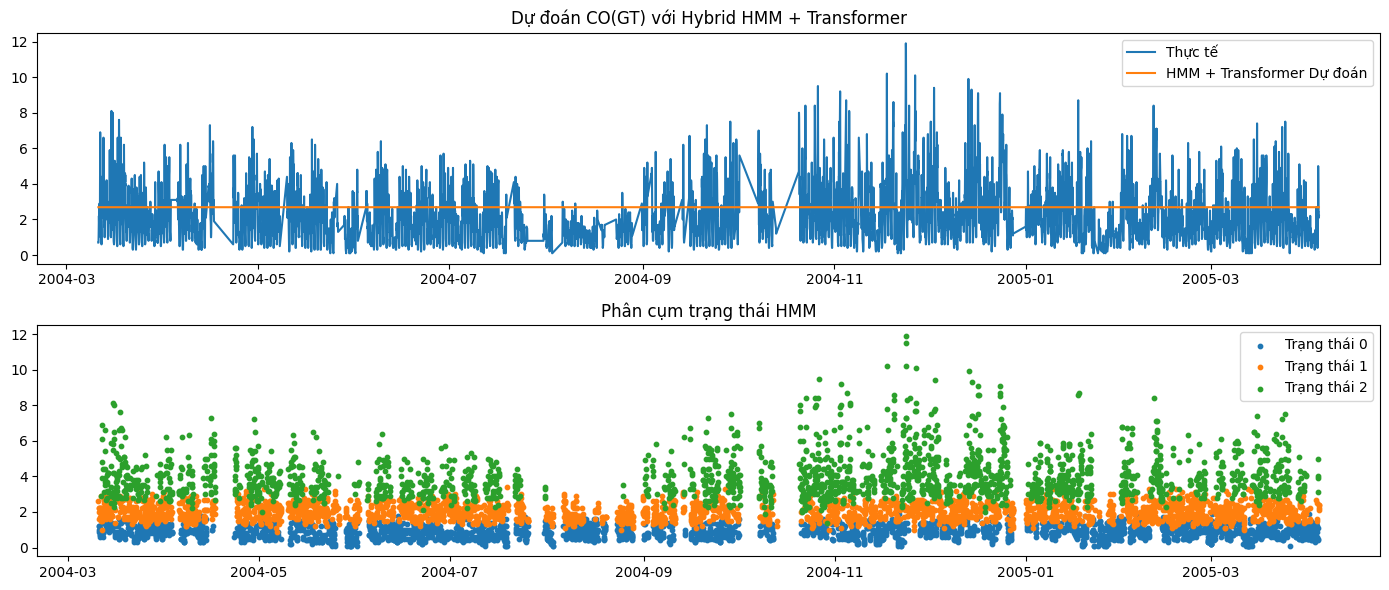

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from hmmlearn.hmm import GaussianHMM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LayerNormalization, MultiHeadAttention, Dropout, Layer
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# === 1. Đọc dữ liệu và xử lý thời gian ===
df = pd.read_csv(
    r"C:\Users\Admin\OneDrive\Documents\Hoc_May\dulieu\tseries_hmm\AirQualityUCI.csv",
    sep=';',
    decimal=',',
    na_values=-200
)
df['Date_Time'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')
df.set_index('Date_Time', inplace=True)
df.drop(columns=['Date', 'Time'], inplace=True)
df = df[['CO(GT)']].dropna()

# === 2. Chuẩn hóa dữ liệu ===
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

# === 3. HMM: Huấn luyện và lấy trạng thái ẩn ===
hmm = GaussianHMM(n_components=3, covariance_type='diag', n_iter=1000)
hmm.fit(data_scaled)
hidden_states = hmm.predict(data_scaled).reshape(-1, 1)

# === 4. Tạo dữ liệu kết hợp HMM + Transformer ===
def create_hybrid_sequence(data, states, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        seq_data = data[i:i+window_size]
        seq_states = states[i:i+window_size]
        combined = np.hstack([seq_data, seq_states])
        X.append(combined)
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 10
X, y = create_hybrid_sequence(data_scaled, hidden_states, window_size)

# === 5. Định nghĩa tầng Transformer tùy chỉnh ===
class TransformerEncoder(Layer):
    def __init__(self, head_size, num_heads, ff_dim, dropout=0, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.head_size = head_size
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout = dropout
        self.attention = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)
        self.dropout1 = Dropout(dropout)
        self.norm1 = LayerNormalization(epsilon=1e-6)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(X.shape[2])  # Đảm bảo kích thước đầu ra khớp với đầu vào
        ])
        self.dropout2 = Dropout(dropout)
        self.norm2 = LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        x = self.attention(inputs, inputs)
        x = self.dropout1(x)
        x = self.norm1(x + inputs)
        ffn_output = self.ffn(x)
        x = self.dropout2(ffn_output)
        return self.norm2(x + ffn_output)

# === 6. Xây dựng và huấn luyện mô hình ===
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    TransformerEncoder(head_size=64, num_heads=4, ff_dim=128, dropout=0.1),
    TransformerEncoder(head_size=64, num_heads=4, ff_dim=128, dropout=0.1),
    # Thêm Flatten để chuyển từ 3D sang 2D trước các tầng Dense
    tf.keras.layers.Flatten(),
    Dense(64, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.fit(X, y, epochs=20, batch_size=32, verbose=1)

# === 7. Dự đoán và hiển thị ===
y_pred = model.predict(X)
# Định dạng lại y_pred từ 3D hoặc 2D sang 2D để tương thích với inverse_transform
y_pred = y_pred.reshape(-1, 1)
y_pred_inv = scaler.inverse_transform(y_pred)
y_true_inv = scaler.inverse_transform(y)

# === 8. Vẽ kết quả ===
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
plt.plot(df.index[window_size:], y_true_inv, label="Thực tế")
plt.plot(df.index[window_size:], y_pred_inv, label="HMM + Transformer Dự đoán")
plt.title("Dự đoán CO(GT) với Hybrid HMM + Transformer")
plt.legend()

plt.subplot(2, 1, 2)
for i in range(hmm.n_components):
    mask = (hidden_states.flatten() == i)
    plt.scatter(df.index[mask], df['CO(GT)'][mask], s=10, label=f"Trạng thái {i}")
plt.title("Phân cụm trạng thái HMM")
plt.legend()
plt.tight_layout()
plt.savefig('prediction_plot.png')
plt.show()
